In [6]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')
from IPython import display

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Training set

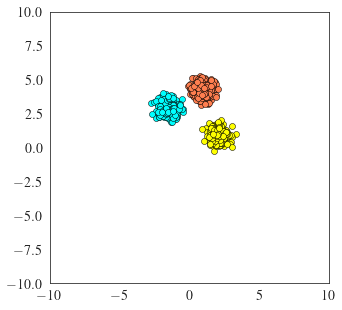

In [7]:
np.random.seed(7777)
size = 1000
train_range = (-7.5, 7.5)


X, Y = datasets.make_blobs(n_samples=size, centers=3, n_features=2, random_state=0, cluster_std=0.4)

# Make it a PyTorch dataset
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).long()
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=size)

test_range = (-10, 10)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='cyan', edgecolors='k', linewidths=0.5)
#plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='green', edgecolors='k', linewidths=0.5)
#plt.scatter(X[Y==4][:, 0], X[Y==4][:, 1], c='purple', edgecolors='k', linewidths=0.5)
plt.xlim(test_range);
plt.ylim(test_range);

In [8]:
def plot(fig, ax, model, colorbar=False, link='mc'):
    # Test data
    # ----------------
    size = 50
    test_rng = np.linspace(*test_range, size)

    X1_test, X2_test = np.meshgrid(test_rng, test_rng)
    X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
    X_test = torch.from_numpy(X_test).float()
    
    # Predict
    # ----------------
    with torch.no_grad():
        if isinstance(model, nn.Module):
            py = torch.softmax(model(X_test), dim=-1).numpy().max(axis=1)
        else:
            py = model(X_test, link_approx=link, n_samples=5000).numpy().max(axis=1)

    conf = py
    
    # Plot
    # ----------------
    ims = []
    cmap = 'Blues'
        
    # Decision boundary contour
    ax.contour(X1_test, X2_test, py.reshape(size, size), 
               levels=[0.5], colors='black', linewidths=[3])

    # Background shade, representing confidence
    conf = np.clip(conf, 0, 0.999999)
    im = ax.contourf(X1_test, X2_test, conf.reshape(size, size), alpha=0.7, 
                     levels=np.arange(0, 1.01, 0.1), cmap=cmap, 
                     vmin=0.5, vmax=1)
    
    if colorbar:
        # new ax with dimensions of the colorbar
        cbar_ax = fig.add_axes([0.95, 0.125, 0.015, 0.75])
        cbar = fig.colorbar(im, cax=cbar_ax)

    # Scatter plot the training data
    ax.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', 
               edgecolors='k', linewidths=0.5)
    ax.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', 
               edgecolors='k', linewidths=0.5)
    ax.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='cyan', 
               edgecolors='k', linewidths=0.5)
    #ax.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='green', 
    #           edgecolors='k', linewidths=0.5)
    #ax.scatter(X[Y==4][:, 0], X[Y==4][:, 1], c='purple', 
    #           edgecolors='k', linewidths=0.5)

    ax.set_xlim(test_range);
    ax.set_ylim(test_range);
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

### Training

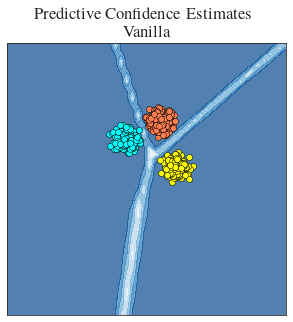

In [9]:
torch.manual_seed(7777)

class Model(nn.Module):
    """
    A three-layer ReLU network
    """
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_map = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 20), 
            nn.ReLU()
        )

        self.clf = nn.Linear(20, 3)
    
    def forward(self, x):
        x = self.feature_map(x)
        return self.clf(x)
    
model = Model()
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

# Marginal likelihood training
for epoch in range(1000):
    # Train as usual
    model.train()
    
    for x, y in train_loader:
        y_pred = model(x).squeeze()
        #print(y_pred)
        l = F.cross_entropy(y_pred, y)
        l.backward()
        opt.step()
        opt.zero_grad()
        
    if epoch % 50 == 0:
        model.eval()

        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(5,5))

        ax.set_title('Vanilla')
        plot(fig, ax, model, colorbar=False)

        plt.suptitle('Predictive Confidence Estimates')
        fig.show()

        display.clear_output(wait=True)
        plt.pause(0.001)

# With Uncertainty!
```
pip install laplace-torch
```

<ipython-input-10-a3d535eafa92>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-8-accfc92f9fe7>:27: UserWarning: No contour levels were found within the data range.
  ax.contour(X1_test, X2_test, py.reshape(size, size),
<ipython-input-10-a3d535eafa92>:84: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


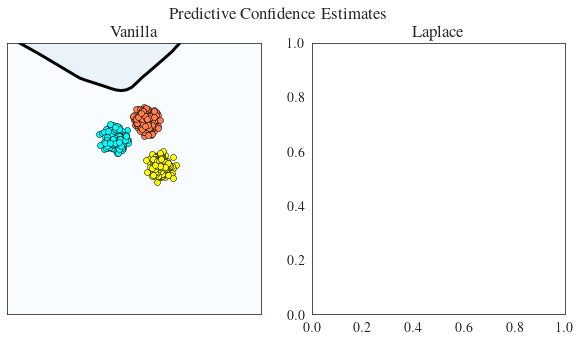

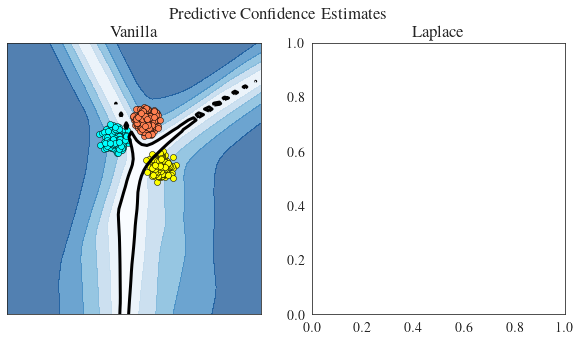

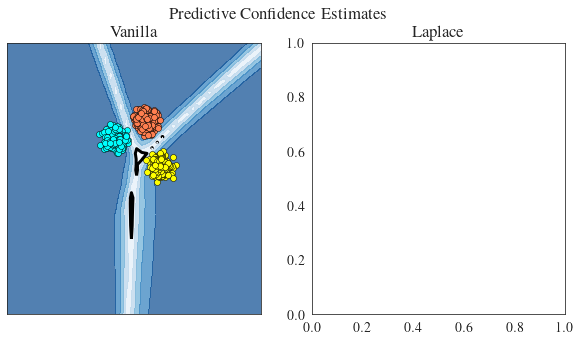

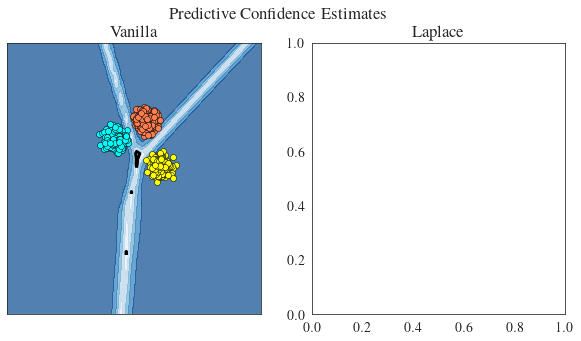

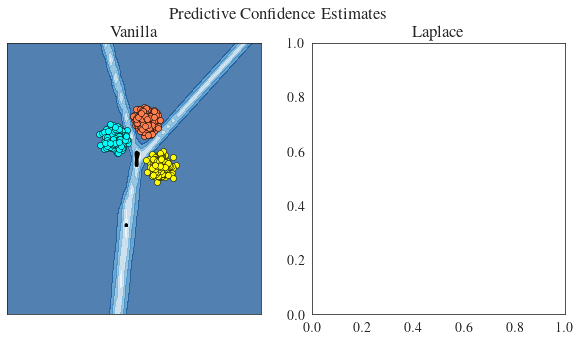

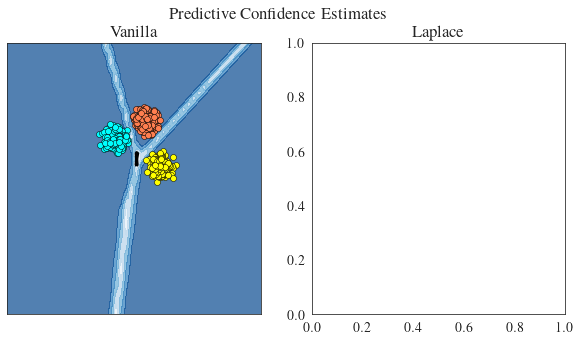

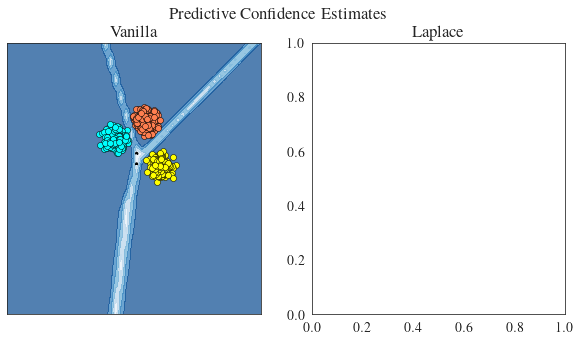

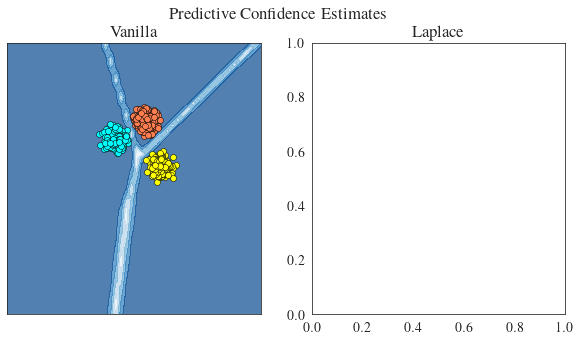

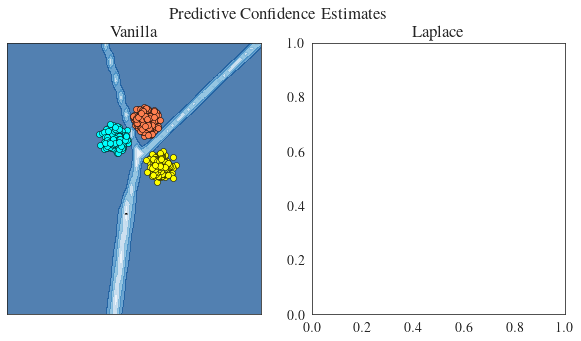

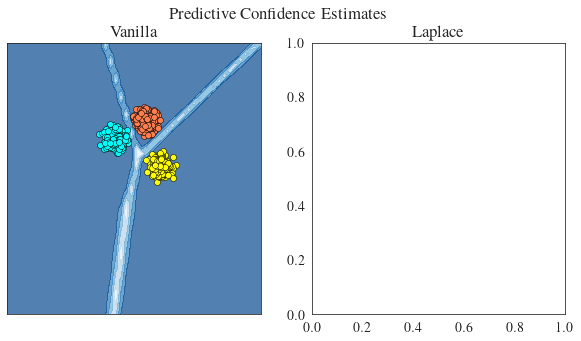

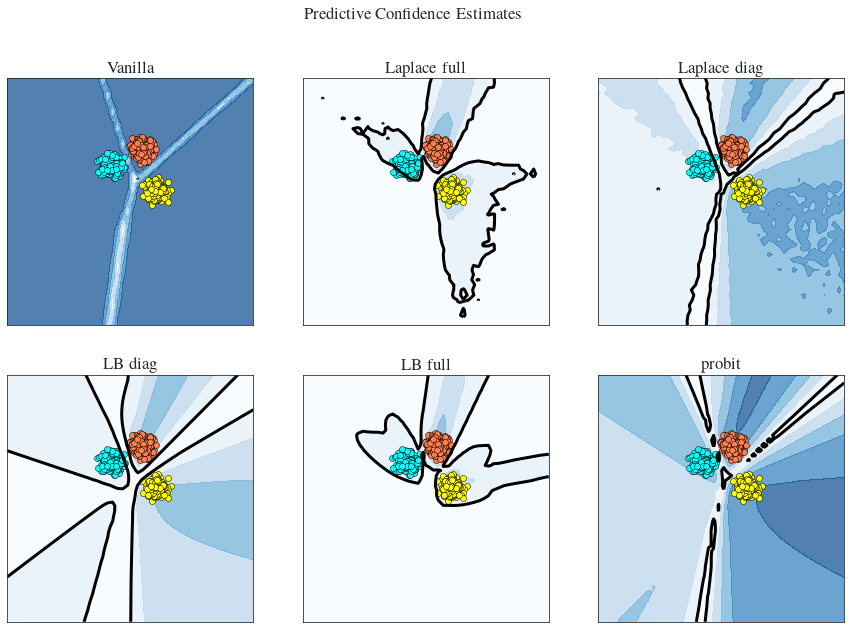

In [10]:
torch.manual_seed(7777)
    
model = Model()
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

################ NEW ################
# Marginal likelihood training
from laplace import Laplace
#####################################

n_iter=1000
for epoch in range(n_iter): #1000
    # Train as usual
    model.train()
    
    for x, y in train_loader:
        y_pred = model(x)
        l = F.cross_entropy(y_pred, y)
        l.backward()
        opt.step()
        opt.zero_grad()
        
    if epoch % 100 == 0:
        model.eval()
        
        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(10,5))

        axs[0].set_title('Vanilla')
        plot(fig, axs[0], model, colorbar=False)

        axs[1].set_title('Laplace')

        plt.suptitle('Predictive Confidence Estimates')
        fig.show()

        #display.clear_output(wait=True)
        #plt.pause(0.001)

    if epoch == n_iter-1:
        
        model.eval()

        ################ LA full ################
        # Step 1. Do a Laplace approx.
        la_full = Laplace(model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='full',
                     prior_precision=5e-4)  # Choose prior precision according to weight decay
        la_full.fit(train_loader)  # Compute and invert Hessian
        #####################################
        
        ################ LA diag ################
        # Step 1. Do a Laplace approx.
        la_diag = Laplace(model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=5e-4)  # Choose prior precision according to weight decay
        la_diag.fit(train_loader)  # Compute and invert Hessian
        #####################################
        
        # Plot
        fig, axs = plt.subplots(2, 3, figsize=(15,10))

        axs[0][0].set_title('Vanilla')
        plot(fig, axs[0][0], model, colorbar=False)

        axs[0][1].set_title('Laplace full')
        plot(fig, axs[0][1], la_full, link='mc', colorbar=False)
        
        axs[0][2].set_title('Laplace diag')
        plot(fig, axs[0][2], la_diag, link='mc', colorbar=False)
        
        axs[1][0].set_title('LB diag')
        plot(fig, axs[1][0], la_diag, link='bridge', colorbar=False)
        
        axs[1][1].set_title('LB full')
        plot(fig, axs[1][1], la_full, link='bridge', colorbar=False)
        
        axs[1][2].set_title('probit')
        plot(fig, axs[1][2], la_diag, link='probit', colorbar=False)

        plt.suptitle('Predictive Confidence Estimates')
        fig.show()

        #display.clear_output(wait=True)
        #plt.pause(0.001)